# Identifying Pneumonina using Convolutional Neural Networks

- Student Name: Kevin Spring
- Student pace: Flex
- Scheduled Project Review: December 12, 2022
- Instructor name: Morgan Jones
- Blog Post

# Summary


# Table of Contents

# Introduction

# Methodology

## Data

In [1]:
# Steps:
# 1. Load data
# 2. Look at sample image and label


import os, shutil

PATH = os.path.join(os.path.abspath(os.getcwd()),'data')
print(PATH)
train_dir = os.path.join(PATH, 'train\\')
val_dir = os.path.join(PATH, 'val\\')
test_dir = os.path.join(PATH, 'test\\')

train_normal = os.path.join(train_dir, 'NORMAL\\')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA\\')


D:\Documents\GitHub\flatiron-data-science\phase04\project\Pneumonia-detection-using-CNN\data


Image number: 1349
normal picture title:  NORMAL2-IM-0877-0001.jpeg
pneumonia picture title: person1446_bacteria_3739.jpeg


Text(0.5, 1.0, 'Pneumonia')

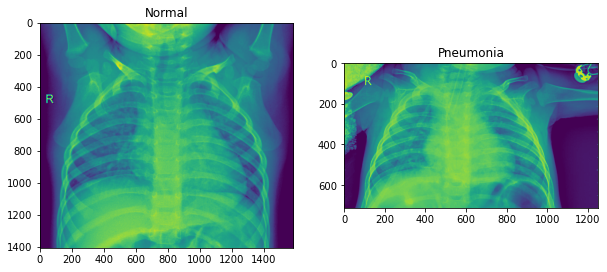

In [12]:
# Show a representative image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print(f'Image number: {len(os.listdir(train_normal))}')
rand_norm = np.random.randint(0, len(os.listdir(train_normal)))
norm_img = os.listdir(train_normal)[rand_norm]
print('normal picture title: ', norm_img)
norm_img_address = train_normal+norm_img

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_pneumonia)))

pneu_img =  os.listdir(train_pneumonia)[rand_norm]
pneu_img_address = train_pneumonia+pneu_img
print('pneumonia picture title:', pneu_img)

# Load the image
norm_load = Image.open(norm_img_address)
pneu_load = Image.open(pneu_img_address)

# Show the picture
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
ax1.set_title('Normal')

ax2 = fig.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneu_load)
ax2.set_title('Pneumonia')

In [13]:
# Import data into tensorflow Dataset object
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

In [14]:
img_height = 64
img_width = 64
batch_size = 64

train_ds = image_dataset_from_directory(train_dir,
                                        color_mode='grayscale',
                                        label_mode='binary',
                                        validation_split=0.2,
                                        subset='training',
                                        seed=42,
                                        image_size=(img_height, img_width),
                                        batch_size = batch_size)

val_ds = image_dataset_from_directory(train_dir,
                                      validation_split=0.2,
                                      color_mode='grayscale',
                                      label_mode='binary',
                                      subset="validation",
                                      seed=42,
                                      image_size=(img_height, img_width),
                                      batch_size=batch_size)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.


In [15]:
print(train_ds.class_names)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['NORMAL', 'PNEUMONIA']
(64, 64, 64, 1)
(64, 1)


In [16]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training your model.
# Dataset.prefetch overlaps data preprocessing and model execution while training.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Standardized the data
normalization_layer = layers.Rescaling(1./255)

In [17]:
# baseline CNN model
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Rescaling
from keras.metrics import SpecificityAtSensitivity

cnn = Sequential()

# Rescaling
cnn.add(Rescaling(1./255, input_shape=(img_height, img_width, 1)))

#Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)))

#Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu"))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn.compile(optimizer = 'adam', 
            loss = 'binary_crossentropy',
            metrics = ['accuracy', 
                       keras.metrics.Precision(),
                       keras.metrics.Recall(),
                       keras.metrics.SpecificityAtSensitivity(0.5),
                       keras.metrics.SensitivityAtSpecificity(0.5)])

# Summary
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0

In [22]:
# Fit the model to the data
#num_of_test_samples = testing_set.samples
#batch_size = 32
epochs=20

cnn_model = cnn.fit(train_ds,
                    #steps_per_epoch = 163,
                    epochs=epochs,
                    validation_data = val_ds,
                    #validation_steps= testing_set.samples
                   )
                   

Epoch 1/20
66/66 [==============================] - 3s 39ms/step - loss: 0.0483 - accuracy: 0.9833 - precision: 0.9868 - recall: 0.9906 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000 - val_loss: 0.0869 - val_accuracy: 0.9675 - val_precision: 0.9860 - val_recall: 0.9711 - val_specificity_at_sensitivity: 1.0000 - val_sensitivity_at_specificity: 1.0000
Epoch 2/20
66/66 [==============================] - 3s 40ms/step - loss: 0.0476 - accuracy: 0.9821 - precision: 0.9877 - recall: 0.9880 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000 - val_loss: 0.1038 - val_accuracy: 0.9627 - val_precision: 0.9599 - val_recall: 0.9925 - val_specificity_at_sensitivity: 0.9960 - val_sensitivity_at_specificity: 1.0000
Epoch 3/20
66/66 [==============================] - 2s 37ms/step - loss: 0.0381 - accuracy: 0.9857 - precision: 0.9912 - recall: 0.9893 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000 - val_loss: 0.0902 - val_accurac

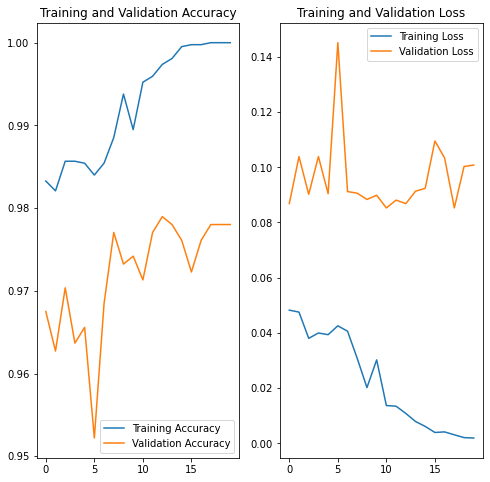

In [23]:
# Visualize training results
acc = cnn_model.history['accuracy']
val_acc = cnn_model.history['val_accuracy']

loss = cnn_model.history['loss']
val_loss = cnn_model.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_accu = cnn.evaluate(testing_set,steps=624)
print('The testing accuracy is :',test_accu[1]*100, '%')